<a href="https://colab.research.google.com/github/Siuumanth/Machine-Learning-and-other-notebooks/blob/main/Document_Image_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing paddleOCR
!pip install paddlepaddle
!pip install paddleocr

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter

# PaddleOCR Initialization
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024/07/14 06:29:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

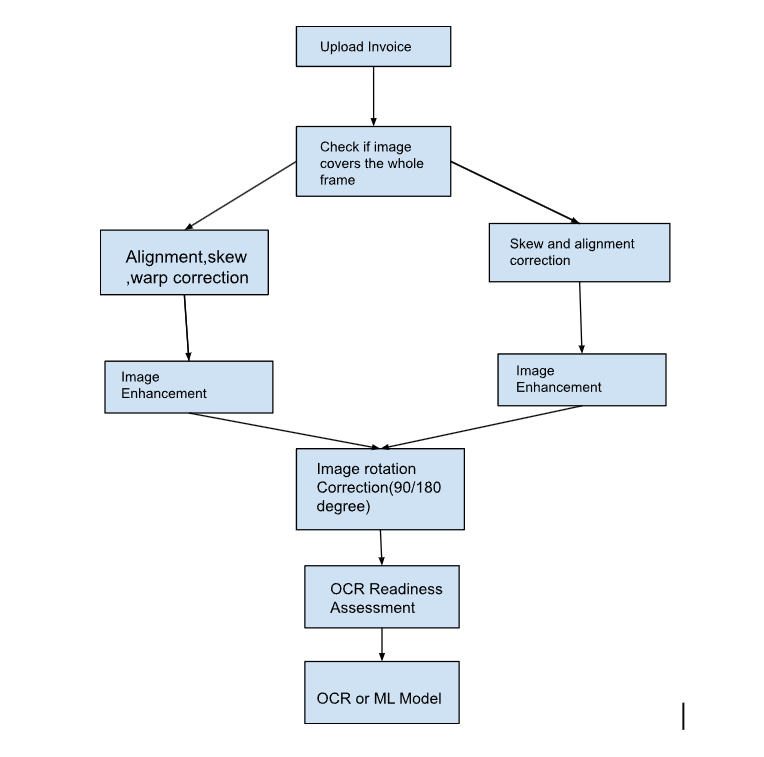

# Defining all the required methods

In [ ]:

# Function to check full frame coverage
def check_full_frame_coverage(image, border_size=40):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    height, width = gray_image.shape

    # Define the border regions top, bottom, left, right
    top_border = gray_image[0:border_size, :]
    bottom_border = gray_image[height-border_size:height, :]
    left_border = gray_image[:, 0:border_size]
    right_border = gray_image[:, width-border_size:width]

    # Calculate the average pixel intensity of the border regions
    top_avg_intensity = np.mean(top_border)
    bottom_avg_intensity = np.mean(bottom_border)
    left_avg_intensity = np.mean(left_border)
    right_avg_intensity = np.mean(right_border)

    # Define the central region
    central_region = gray_image[border_size:height-border_size, border_size:width-border_size]

    # Calculate the average pixel intensity of the central region
    central_avg_intensity = np.mean(central_region)

    # Calculate the overall average border intensity
    overall_border_avg_intensity = (top_avg_intensity + bottom_avg_intensity + left_avg_intensity + right_avg_intensity) / 4

    # Compare the average intensities
    if abs(overall_border_avg_intensity - central_avg_intensity) < 20:  # Adjust the threshold as needed
        return True  # The document likely covers the entire frame
    else:
        return False  # The document does not cover the entire frame





# a reorder corners function that is used in the alignment correction method

def reorder_corners(pts):
    # Create an array to hold the reordered corners
    rect = np.zeros((4, 2), dtype="float32")

    # Calculate the sums and differences of coordinates
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    # Assign the corners based on their sums and differences
    rect[0] = pts[np.argmin(s)]       # Top-left corner has the smallest sum
    rect[2] = pts[np.argmax(s)]       # Bottom-right corner has the largest sum
    rect[1] = pts[np.argmin(diff)]    # Top-right corner has the smallest difference
    rect[3] = pts[np.argmax(diff)]    # Bottom-left corner has the largest difference

    return rect


def make_full_frame(image):


    # Convert to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Apply edge detection (Canny edge detection example)
    edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)  #threshold 1 of 50 or 70 should work fine
    #edges = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2) this is for adaptive parameters, but it doesnt seem to work too well.


    # Perform dilation and erosion
    kernel = np.ones((3,3), np.uint8)  # Kernel for dilation and erosion
    dilated_img = cv2.dilate(edges, kernel, iterations=1)
    eroded_img = cv2.erode(dilated_img, kernel, iterations=1)

    # Get all contours
    contours, _ = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Ensure we have exactly 4 points on the largest contour
    if len(approx_contour) != 4:
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        approx_contour = np.int0(box)
    else:
        approx_contour = approx_contour.reshape((4, 2))

    ordered_corners = reorder_corners(approx_contour)

    #Define the destination points and compute the perspective transform matrix.
    height, width = image.shape[:2]
    dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered_corners, dst_pts)

    warped_img = cv2.warpPerspective(image, M, (width, height))

    return warped_img
    #after this method , the image will be full frame, so it can be passed to the process_full_frame method


#Better not include this method
#in-document lines skew correction
def process_full_frame(image):
    #gray_warped = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection on the warped image
   # edges_warped = cv2.Canny(gray_warped, 50, 150, apertureSize=3)

    # Perform Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(image, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Calculate average angle of detected lines
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
        angles.append(angle)

    mean_angle = np.mean(angles)

    # Correct skew by rotating the warped image
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -mean_angle, 1)
    skew_corrected_img = cv2.warpAffine(image, M, (cols, rows))

    return skew_corrected_img


def image_enhancement(image):
    # Convert to grayscale
    gray_cropped_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred_img = cv2.GaussianBlur(gray_cropped_img, (3, 3), 0)

    #_, thresh_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh_img = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

    denoised_img = cv2.bilateralFilter(thresh_img, 5, 75, 75)

    # Apply morphological operations (closing) to close gaps between edges of letters
    kernel = np.ones((3, 3), np.uint8)
    morph_img = cv2.morphologyEx(denoised_img, cv2.MORPH_CLOSE, kernel)

    # Invert colors
    inverted_img = cv2.bitwise_not(morph_img)
    return inverted_img


#tilt correction
def correct_tilt(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

   # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return corrected





#The code for image rotation correction is still yet to be built ... as it might require to use paddleOCR and some research
def rotation_correction(image):
  return True




def ocr_assessment(image, ocr_readiness_threshold = 0.98):
    result = ocr.ocr(image, cls=True)  #you can return this Extracted text as well and use it for the model


    total_confidence = 0
    total_regions = 0


    for line in result:
        # Extract the confidence score and text from each detected text region
        text, confidence = line[-1][-1]
        total_confidence += confidence
        total_regions += 1

    if total_regions > 0:
        average_confidence = total_confidence / total_regions
    else:
        average_confidence = 0



    # Classify based on OCR readiness metrics
    if average_confidence >= ocr_readiness_threshold:
        return True
    else:
        return False








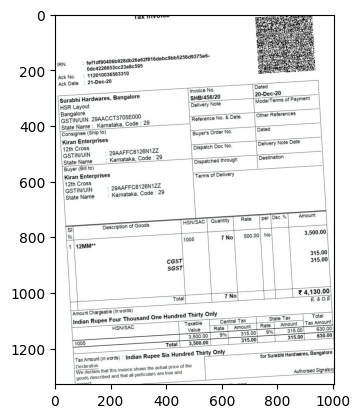

In [ ]:
#Select an image
img=cv2.imread('/content/drive/MyDrive/invoices/Research/Test 4/original4.jpg')
plt.imshow(img,cmap='gray')

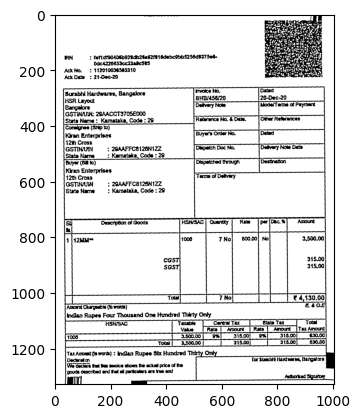

In [ ]:
if check_full_frame_coverage(img):

    enhanced_image=image_enhancement(img)

   # skew_corrected_image = process_full_frame(enhanced_image) # this method needs tweaking as it doenst work well

    final_image = correct_tilt(enhanced_image)

    plt.imshow(final_image,cmap='gray')


else:
    warped_image = make_full_frame(img)

    enhanced_image=image_enhancement(warped_image)

   # skew_corrected_image = process_full_frame(enhanced_image) # this method needs tweaking as it doenst work well

    final_image = correct_tilt(enhanced_image)

    plt.imshow(final_image,cmap='gray')


In [ ]:
cv2.imwrite('/content/drive/MyDrive/invoices/Research/Test 4/noisy.jpg',final_image)

True

In [ ]:
cv2.imwrite('img original.jpg',img)

True